# Community graph

## Imports

In [8]:
import os

import pandas as pd
import numpy as np

from tqdm import tqdm

import seaborn
import matplotlib.cm as cm
import matplotlib.pyplot as plt

import networkx as nx
import community.community_louvain as community_louvain

## Reading data

In [43]:
clean_tweets = pd.read_csv('clean_masks.csv')
clean_tweets['rtt_author_ids'].map(to_int)[0][0]

1073646674030018560

## Data insight

c:\users\artorias_doge\appdata\local\programs\python\python37\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

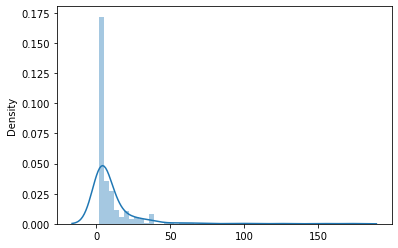

In [10]:
a = np.array(clean_tweets['retweet_count'])
a = a[a > 0]
a = a[a < 200]
seaborn.distplot(a)

In [11]:
# saving to csv converts lists to str so have to convert it back
def to_int(l):
    L = l.replace(' ','').replace('[','').replace(']','').split(',')
    return [int(x) for x in L]

def filter(df):
    """
    Filters out tweets that have no retweets, non FR tweet,
    authors with less than 1000 favs and converts str to
    lists of int back (due to pd format)
    
    in: pandas.DataFrame
    
    out: pandas.DataFrame
    """
    res = df[df['rtt_author_ids'].notnull()]
    res = res[res['user_country'] == 'FR']
    res = res[res['retweet_count'] > 1]
    res = res[res['favourites_count'] > 1000]
    res['rtt_author_ids'] = res['rtt_author_ids'].map(to_int)
    print('There are {} tweets that had at least one rtt, among a total of {} users'.format(len(df), len(np.unique(df['author_id']))))
    return res

In [12]:
df = filter(clean_tweets)

There are 307 tweets that had at least one rtt, among a total of 266 users


### Date

c:\users\artorias_doge\appdata\local\programs\python\python37\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


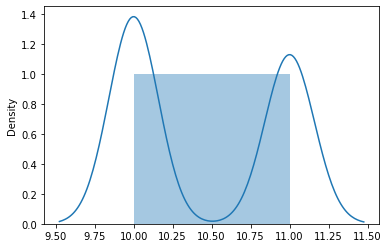

In [13]:
def plot_dates(df, date_col_name):
    temp = [d[:10].split('-')[2] for d in df[date_col_name]]
    temp = np.sort([int(x) for x in temp])
    bins = int(np.max(temp) - np.min(temp))
    plot = seaborn.distplot(temp, bins = bins)
    
plot_dates(df, 'publishing_date')

### Favourites

c:\users\artorias_doge\appdata\local\programs\python\python37\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

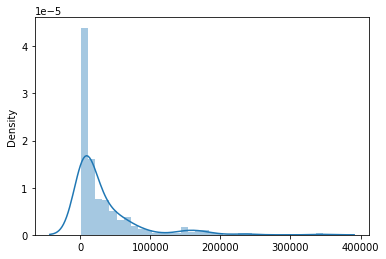

In [14]:
seaborn.distplot(np.array(df['favourites_count']))

In [15]:
min_fav = np.min(df['favourites_count'])
max_fav = np.max(df['favourites_count'])
median_fav = np.median(df['favourites_count'])
mean_fav = np.mean(df['favourites_count'])

print(r"""favourites:
min: {}
max: {}
mean: {}
median: {}""".format(min_fav, max_fav, mean_fav, median_fav))

favourites:
min: 1078
max: 346431
mean: 31742.40716612378
median: 13463.0


### Friends

c:\users\artorias_doge\appdata\local\programs\python\python37\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

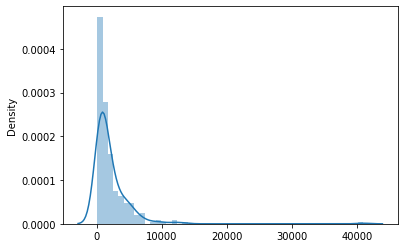

In [16]:
seaborn.distplot(np.array(df['friends_count']))

In [17]:
min_f = np.min(df['friends_count'])
max_f = np.max(df['friends_count'])
median_f = np.median(df['friends_count'])
mean_f = np.mean(df['friends_count'])

print(r"""friends:
min: {}
max: {}
mean: {}
median: {}""".format(min_f, max_f, mean_f, median_f))

friends:
min: 44
max: 40987
mean: 2061.0814332247555
median: 1109.0


## Naive Louvain algorithm

In [18]:
def modularity(A, communities):
    """
    Computes the modularity of a given network and communities
    
    A: adjency matrix
    communities : list of assigned communities
    
    returns: the computed modularity
    """
    m = np.sum(A)
    k = np.sum(A, axis = 0)
    Q = 0
    for i in range(A.shape[0]):
        for j in range(A.shape[1]):
            if(communities[i] == communities[j]):
                Q = Q + A[i,j] - (k[i]*k[j]) / (2 * m)
                
    return Q / (2 * m)

def find_best_neighbors(A, communities):
    """
    Performs a single iteration of finding a potential neighbor to each node
    
    A: adjency matrix
    communities : list of assigned communities
    
    returns: the resulting communities
    """
    res = communities
    N = A.shape[0]
    Q = modularity(A, res)
    for node in tqdm(range(N)):
        best = node
        # gets the indexes of nodes with which i has a link with
        l = np.arange(N)[A[node] != 0]
        for neigh in l:
            communities_ = res
            # assigns node to its neighbor community
            communities_[node] = res[neigh]
            Q_ = modularity(A, communities_)
            if Q_ > Q:
                Q = Q_
                best = neigh
        
        temp = res[best]
        res[node] = temp
    return res

def join_communities(A, communities):
    C = np.unique(communities)
    A_ = np.zeros((len(C), len(C)))
    for (i,c) in tqdm(enumerate(C)):
        l = A[communities == c]
        for (j,c_) in enumerate(C):
            if c != c_:
                n = np.sum(np.sum(l, axis = 0)[communities == c_])
                A_[i,j] = n
                
    return A_

A = np.array([
    [0, 1, 1, 0, 0, 0, 0, 0],
    [1, 0, 1, 1, 1, 0, 0, 0],
    [1, 1, 0, 0, 0, 0, 0, 0],
    [0, 1, 0, 0, 1, 0, 0, 0],
    [0, 1, 0, 1, 0, 1, 0, 0],
    [0, 0, 0, 0, 1, 0, 1, 1],
    [0, 0, 0, 0, 0, 1, 0, 1],
    [0, 0, 0, 0, 0, 1, 1, 0]
])

C = [0,1,2,3,4,5,6,7]

C = find_best_neighbors(A, C)
join_communities(A, C)

100%|██████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 8025.46it/s]
4it [00:00, ?it/s]


array([[0., 1., 1., 0.],
       [1., 0., 1., 0.],
       [1., 1., 0., 1.],
       [0., 0., 1., 0.]])

## Running Louvain

In [19]:
def build_rtt_graph(df):
    """
    Builds the graph with an edge representing a retweet and
    each edge having the sentiment as weight
    
    in: pandas.DataFrame
    
    out: networkx.Graph
    """
    
    ## Authors
    tweet_authors = np.unique(df['author_id'].to_numpy(dtype = 'int64'))
    retweet_authors = np.unique(np.concatenate(df['rtt_author_ids'].to_numpy()))
    
    G = nx.Graph()
    
    ## ADDING NODES
    # adding authors that tweeted, with their screen name
    for i in range(len(tweet_authors)):
        sn = df[df['author_id'] == tweet_authors[i]]['screen_name'].iloc[0]
        G.add_node(tweet_authors[i], screen_name = sn)

    # adding retweeting authors with empty string as screen name
    for a in retweet_authors:
        if a not in tweet_authors:
            G.add_node(a, screen_name = '')
            
    ## ADDING EDGES
    # creating edges with sentiment as weight
    L1 = np.array(df['author_id'])
    L2 = np.array(df['rtt_author_ids'])
    L3 = np.array(np.abs(df['sentiment']))

    for i in range(len(L1)):
        for a in L2[i]:
            G.add_edge(L1[i], a, weight = L3[i])

    return G

def remove_not_connected(G):
    """
    Only keeps the largest connected component of the graph and returns a copy of it
    
    in: networkx.Graph
    
    out: networkx.Graph
    """
    num_connected_components = nx.number_connected_components(G)
    print('There are {} connected components in the graph'.format(num_connected_components))
    connected_components = nx.connected_components(G)
    
    l = []
    for i in nx.connected_components(G):
        l.append(len(i))
    l.sort(reverse = True)
    print('The largest component has {} nodes. the second largest has {} nodes'.format(l[0], l[1]))
    
    max_cc = max(connected_components, key = len)
    return G.subgraph(max_cc).copy()

def plot_Louvain(G, partition):
    pos = nx.spring_layout(S)
    cmap = cm.get_cmap('viridis', max(partition.values()) + 1)
    nx.draw_networkx_nodes(
        G,
        pos,
        partition.keys(),
        node_size=40,
        cmap=cmap,
        node_color=list(partition.values())
    )
    nx.draw_networkx_edges(G, pos, alpha=0.5)
    plt.show()
    
def generate_subgraphs(G):
    partitions = community_louvain.best_partition(G)
    num_partitions = len(np.unique(list(partitions.values())))
    print('Number of partitions: {}'.format(num_partitions))
    
    sets = []
    
    for i in range(num_partitions):
        sets.append(set())
        
    for k, v in partitions.items():
        sets[v].add(k)
        
    subgraphs = [G.subgraph(s).copy() for s in sets]    
    return subgraphs

def save_graphs(path, graphs):
    for f in os.listdir(path):
        os.remove(os.path.join(path, f))
        
    for (i, subgraph) in enumerate(graphs):
        N = len(subgraph)
        if(N > 100):
            nx.write_gexf(subgraphs[i], os.path.join('graphs', 'G{}_{}.gexf'.format(i, N)))

In [20]:
G = build_rtt_graph(df)
G = remove_not_connected(G)

TypeError: bad operand type for abs(): 'str'

In [15]:
subgraphs = generate_subgraphs(G)

Number of partitions: 54


In [16]:
save_graphs('graphs', subgraphs)

In [7]:
os.path.exists('graphs')

True